# Image classification (5 class of flowers: Tulips, Roses, Daisy, Dandelion, Sunflowers)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
import urllib.request

In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


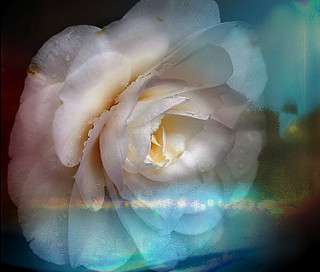

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

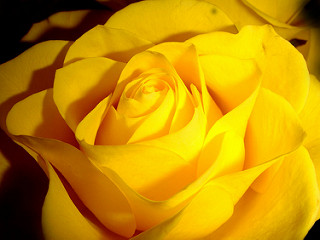

In [5]:
PIL.Image.open(str(roses[1]))

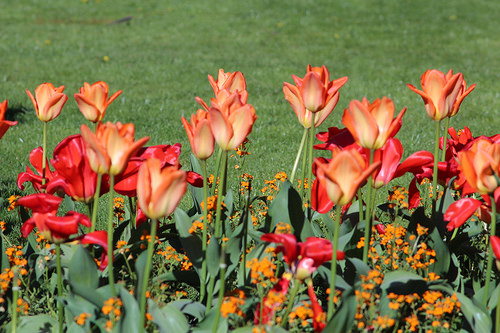

In [6]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

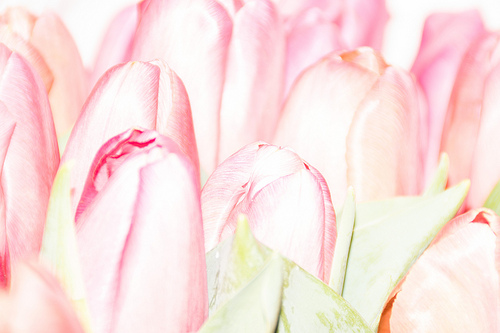

In [7]:
PIL.Image.open(str(tulips[1]))

## Create a dataset

In [8]:
batch_size = 32
img_height = 180
img_width = 180

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, validation_split = 0.2, subset="training",
    seed = 123, image_size=(img_height,img_width),
    batch_size = batch_size)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, validation_split = 0.2, subset="validation",
    seed = 123, image_size=(img_height,img_width),
    batch_size = batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the data

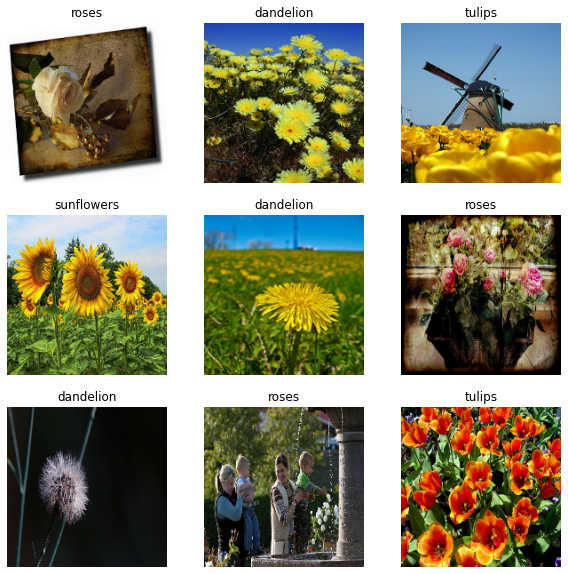

In [11]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x),y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


## Data augmentation

In [16]:
data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",input_shape=(img_height,img_width,3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
])

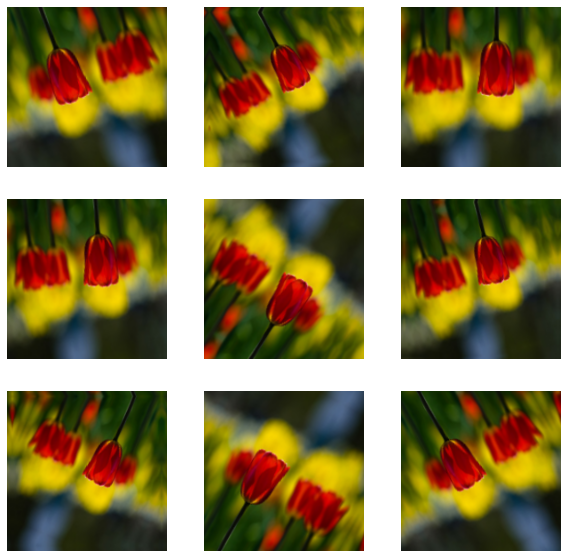

In [17]:
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3,3,i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Build and train the model with augmented data

In [18]:
num_classes = 5

model = tf.keras.models.Sequential([
    data_augmentation,
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(16,3,padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32,3,padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64,3,padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128,3,padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256,3,padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

In [19]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)       

In [21]:
epochs = 30
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/30
92/92 [==============================] - 7s 49ms/step - loss: 1.3203 - accuracy: 0.4193 - val_loss: 1.1387 - val_accuracy: 0.4986
Epoch 2/30
92/92 [==============================] - 3s 37ms/step - loss: 1.0677 - accuracy: 0.5497 - val_loss: 0.9887 - val_accuracy: 0.6104
Epoch 3/30
92/92 [==============================] - 3s 37ms/step - loss: 0.9397 - accuracy: 0.6219 - val_loss: 0.9317 - val_accuracy: 0.6240
Epoch 4/30
92/92 [==============================] - 3s 37ms/step - loss: 0.8759 - accuracy: 0.6584 - val_loss: 0.9443 - val_accuracy: 0.6362
Epoch 5/30
92/92 [==============================] - 3s 37ms/step - loss: 0.8495 - accuracy: 0.6614 - val_loss: 0.8045 - val_accuracy: 0.6717
Epoch 6/30
92/92 [==============================] - 3s 37ms/step - loss: 0.7949 - accuracy: 0.6795 - val_loss: 0.8154 - val_accuracy: 0.6812
Epoch 7/30
92/92 [==============================] - 3s 37ms/step - loss: 0.7611 - accuracy: 0.7020 - val_loss: 0.8163 - val_accuracy: 0.6826
Epoch 8/30
92

## Visualize training results

Text(0.5, 1.0, 'Training and Validation Loss')

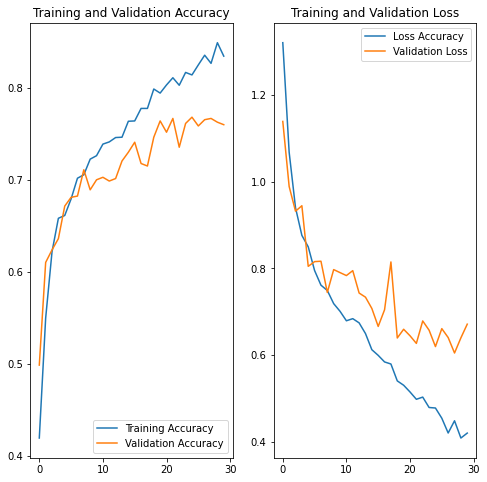

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Training Accuracy')
plt.plot(epochs_range,val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Loss Accuracy')
plt.plot(epochs_range,val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

## Making some predictions

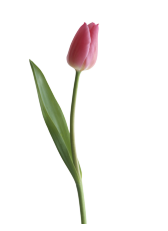

This image is a tulip with 99.90 % of probability.




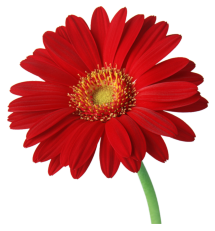

This image is a daisy with 99.93 % of probability.




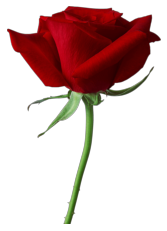

This image is a rose with 65.83 % of probability.




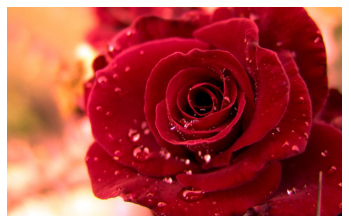

This image is a rose with 96.60 % of probability.




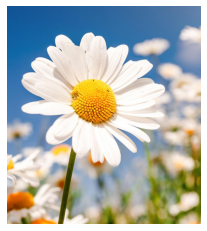

This image is a daisy with 99.99 % of probability.




In [23]:
vector = {"tulip":"https://freepngimg.com/thumb/tulip/4-2-tulip-png-clipart.png",
          "daisy":"https://freepngimg.com/thumb/gerbera/27676-5-gerbera-transparent-background.png",
          "rose":"https://freepngimg.com/thumb/rose/1-rose-png-image-picture-download.png",
          "rose_2":"https://i.pinimg.com/originals/95/af/ff/95afff4bbe201992e64ea8ea28aad0bd.jpg",
          "daisy_2":"https://cdn2.stylecraze.com/wp-content/uploads/2013/11/Top-25-Most-Beautiful-Daisy-Flowers.jpg"}
print("\n")

for key,value in vector.items():
    path = tf.keras.utils.get_file(key,origin=value)
    img = tf.keras.preprocessing.image.load_img(path,target_size=(img_height,img_width))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array,0)
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    im = PIL.Image.open(urllib.request.urlopen(value),'r')
    plt.imshow(im)
    plt.axis("off")
    plt.show()
    
    if(class_names[np.argmax(score)]=="daisy"):
        print("This image is a daisy with {:.2f} % of probability.".format(100*np.max(score)))
        print("\n")
    elif(class_names[np.argmax(score)]=="dandelion"):
        print("This image is a dandelion with {:.2f} % of probability.".format(100*np.max(score)))
        print("\n")
    elif(class_names[np.argmax(score)]=="roses"):
        print("This image is a rose with {:.2f} % of probability.".format(100*np.max(score)))
        print("\n")
    elif(class_names[np.argmax(score)]=="suflowers"):
        print("This image is a sunflower with {:.2f} % of probability.".format(100*np.max(score)))
        print("\n")
    elif(class_names[np.argmax(score)]=="tulips"):
        print("This image is a tulip with {:.2f} % of probability.".format(100*np.max(score)))
        print("\n")
    else:
        print("Not certain of what it is")
        print("\n")